#Dirichlet Process Gaussian Mixture Model (DP-GMM)
---

###Let's set up our environment

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import time
import seaborn as sns
import pandas as pd
sns.set_style('darkgrid')
sns.set_context('talk')
sns.set_palette("Set2", 30)

###Now let's import our functions from datamicroscopes

In [2]:
from microscopes.common.rng import rng
from microscopes.common.recarray.dataview import numpy_dataview
from microscopes.models import niw as normal_inverse_wishart
from microscopes.mixture.definition import model_definition
from microscopes.mixture import model, runner, query
from microscopes.common.query import zmatrix_heuristic_block_ordering, zmatrix_reorder

###From here, we'll generate four isotropic 2D gaussian clusters in each quadrant, varying the scale parameter

In [3]:
nsamples_per_cluster = 100
means = np.array([[1, 1], [1, -1], [-1, -1], [-1, 1]], dtype=np.float)
scales = np.array([0.08, 0.09, 0.1, 0.2])
Y_clusters = [
    np.random.multivariate_normal(
        mean=mu, 
        cov=var * np.eye(2), 
        size=nsamples_per_cluster) 
    for mu, var in zip(means, scales)]
df = pd.DataFrame()
for i, Yc in enumerate(Y_clusters):
    cl = pd.DataFrame(Yc, columns = ['x','y'])
    cl['cluster'] = i
    df = df.append(cl)
Y = np.vstack(Y_clusters)
Y = np.random.permutation(Y)

In [4]:
df.head()

,x,y,cluster
0,1.557005,1.266202,0
1,1.465262,0.842641,0
2,0.619352,1.309368,0
3,1.130965,0.700129,0
4,1.447409,1.112726,0


###Let's have a look at the generated data

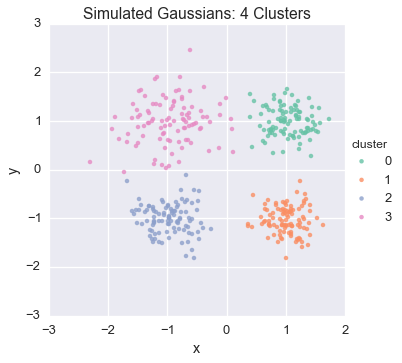

In [5]:
sns.lmplot('x', 'y', hue="cluster", data=df, fit_reg=False)
plt.title('Simulated Gaussians: 4 Clusters')

##Now let's learn this clustering non-parametrically!

##There are 5 steps necessary to set up your model:

1. Decide on the number of chains we want -- it is important to run multiple chains from different starting points!

2. Define our DP-GMM model

3. Munge the data into numpy recarray format then wrap the data for our model

4. Randomize start points

5. Create runners for each chain

In [6]:
nchains = 8

# The random state object
prng = rng()

# Define a DP-GMM where the Gaussian is 2D
defn = model_definition(Y.shape[0], [normal_inverse_wishart(2)])

# Munge the data into numpy recarray format
Y_rec = np.array([(list(y),) for y in Y], dtype=[('', np.float32, 2)])

# Create a wrapper around the numpy recarray which 
# data-microscopes understands
view = numpy_dataview(Y_rec)

# Initialize nchains start points randomly in the state space
latents = [model.initialize(defn, view, prng) for _ in xrange(nchains)]

# Create a runner for each chain
runners = [runner.runner(defn, view, latent, kernel_config=['assign']) for latent in latents]

###We will visualize our data to examine the cluster assignment

In [7]:
def plot_assignment(assignment, data=Y):
    cl = pd.DataFrame(data, columns = ['x','y'])
    cl['cluster'] = assignment
    n_clusters = cl['cluster'].nunique()
    sns.lmplot('x', 'y', hue="cluster", data=cl, fit_reg=False, legend=(n_clusters<10))
    plt.title('Simulated Gaussians: %d Learned Clusters' % n_clusters)

##Let's peek at the starting state for one of our chains

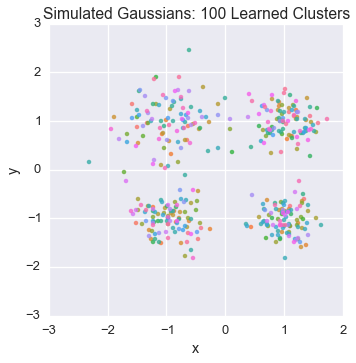

In [8]:
plot_assignment(latents[0].assignments())

##Let's watch one of the chains evolve for a few steps

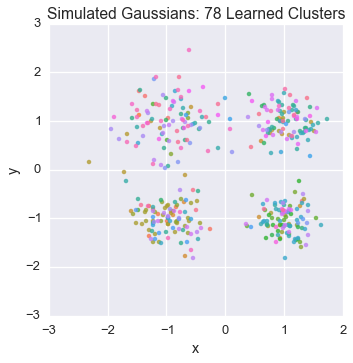

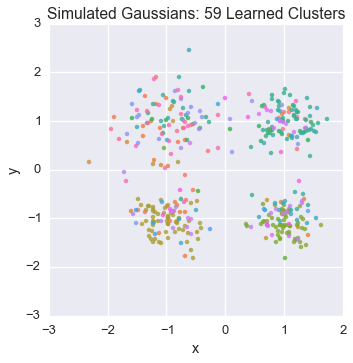

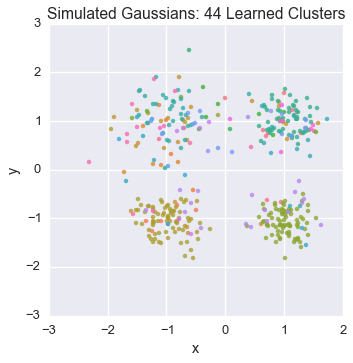

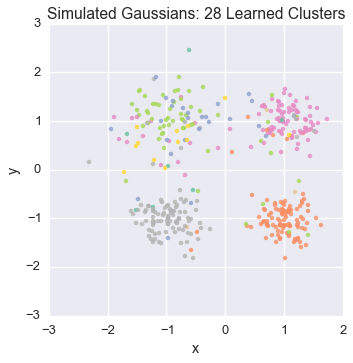

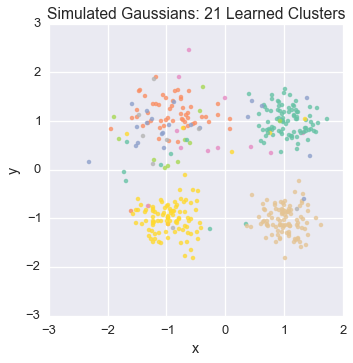

In [9]:
first_runner = runners[0]
for i in xrange(5):
    first_runner.run(r=prng, niters=1)
    plot_assignment(first_runner.get_latent().assignments())

# Now let's burn all our runners in for 100 iterations.

We'll do this sequentially since the model is simple, but check microscopes.parallel.runner for parallel implementions (with support for either multiprocessing or multyvac)

In [10]:
for runner in runners:
    runner.run(r=prng, niters=100)

#Let's now peek again at the first state

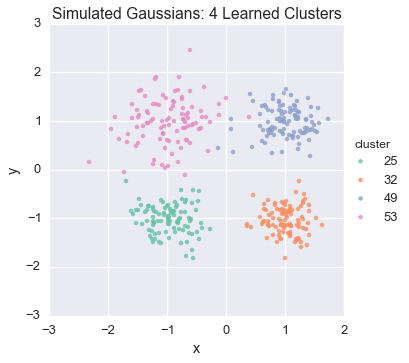

In [11]:
plot_assignment(first_runner.get_latent().assignments())

##Let's build a z-matrix to compare our result with the rest of the chains

We'll be sure to sort our z-matrix before plotting. Sorting the datapoints allows us to organize the clusters into a block matrix.

In [12]:
infers = [r.get_latent() for r in runners]
zmat = query.zmatrix(infers)
ordering = zmatrix_heuristic_block_ordering(zmat)
zmat = zmatrix_reorder(zmat, ordering)

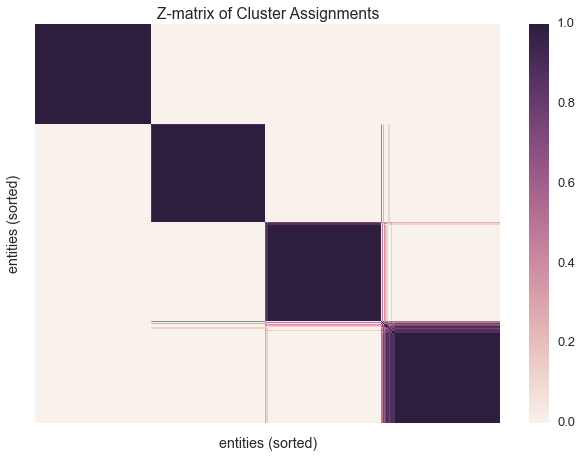

In [13]:
sns.heatmap(zmat, linewidths=0, xticklabels=False, yticklabels=False)
plt.xlabel('entities (sorted)')
plt.ylabel('entities (sorted)')
plt.title('Z-matrix of Cluster Assignments')